In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

In [3]:
# download mnist dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

In [4]:
X, y = mnist.data, mnist.target # 28 * 28像素的黑白图片
X.shape, y.shape

((70000, 784), (70000,))

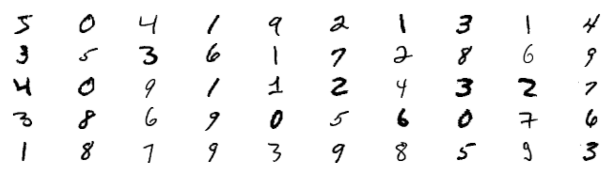

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4']
['3' '5' '3' '6' '1' '7' '2' '8' '6' '9']
['4' '0' '9' '1' '1' '2' '4' '3' '2' '7']
['3' '8' '6' '9' '0' '5' '6' '0' '7' '6']
['1' '8' '7' '9' '3' '9' '8' '5' '9' '3']


In [5]:
_, axes = plt.subplots(5, 10, figsize=(8, 2))
rows, columns = axes.shape
for i in range(rows):
    for j in range(columns):
        digit_image_data = X[i * columns + j]
        image = digit_image_data.reshape(28, 28)
        axes[i, j].imshow(image, cmap="binary")
        axes[i, j].axis("off")
plt.show()
for i in range(rows):
    print(y[i * columns : (i + 1) * columns])

In [6]:
# mnist的训练集和测试集已经拆分好了
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train

array(['5', '0', '4', ..., '5', '6', '8'], shape=(60000,), dtype=object)

In [8]:
# 二元分类器
y_train_5 = (y_train == "5") # if target is 5, return True
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [9]:
sgd_clf.predict(X[[0, 10, 11, 47]])

array([ True, False,  True,  True])

In [10]:
# 3 K折交叉验证
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm, cm[1, 1] / (cm.sum(axis=0)[-1]), cm[1, 1] / (cm.sum(axis=-1)[-1])

(array([[53892,   687],
        [ 1891,  3530]]),
 np.float64(0.8370879772350012),
 np.float64(0.6511713705958311))

In [34]:
p_score = precision_score(y_train_5, y_train_pred)
r_score = recall_score(y_train_5, y_train_pred)
f1_score = f1_score(y_train_5, y_train_pred)

print(p_score, r_score, f1_score)

0.8370879772350012 0.6511713705958311 0.7325171197343847


In [35]:
2 * (p_score * r_score) / (p_score + r_score)

0.7325171197343846

In [15]:
sgd_clf.decision_function(X[[0, 10, 11, 47]])

array([ 2164.22030239, -5711.47789687,  4742.52813158,  9895.8092942 ])

In [16]:
y_train_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_train_scores.shape

(60000,)

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_scores)

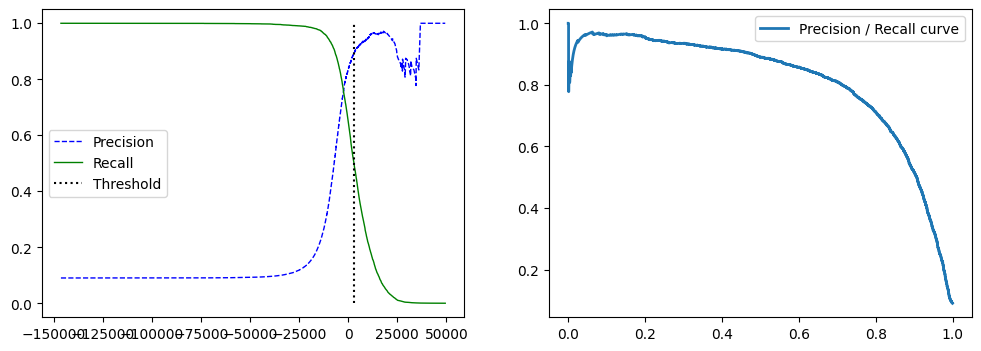

In [20]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth="1")
axes[0].plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth="1")
axes[0].vlines(3000, 0, 1.0, "k", "dotted", label="Threshold")
axes[0].legend()

axes[1].plot(recalls, precisions, linewidth="2", label="Precision / Recall curve")
axes[1].legend()

plt.show()

In [42]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(idx_for_90_precision, thresholds[idx_for_90_precision])

57109 3370.0194991441826


In [26]:
y_train_90_pred = y_train_scores >= thresholds[idx_for_90_precision]
y_train_90_pred[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [29]:
precision_score(y_train_5, y_train_90_pred)

0.9000345901072293

In [36]:
recall_score(y_train_5, y_train_90_pred)

0.4799852425751706

In [24]:
y_train_5

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [44]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_train_scores)

In [46]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

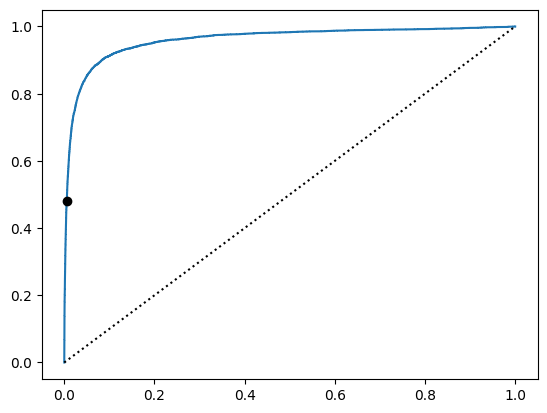

In [49]:
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], "k:")
plt.plot([fpr_90], [tpr_90], "ko")
plt.show()